In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

In [2]:
training_data = datasets.MNIST(
root='data',
download=True,
train=True,
transform=ToTensor())

test_data = datasets.MNIST(
root='data',
download=True,
train=False,
transform=ToTensor())

100%|██████████| 9912422/9912422 [00:01<00:00, 7284508.18it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28814389.59it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7344829.44it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4539082.38it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
training_data.classes

mapping = {training_data.classes.index(x):x[:1] for x in training_data.classes}

mapping

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

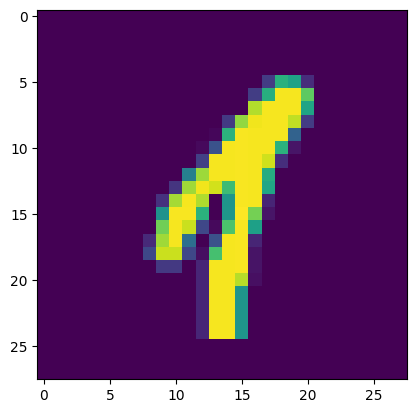

1


In [5]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img)
plt.show()
print(label.item())

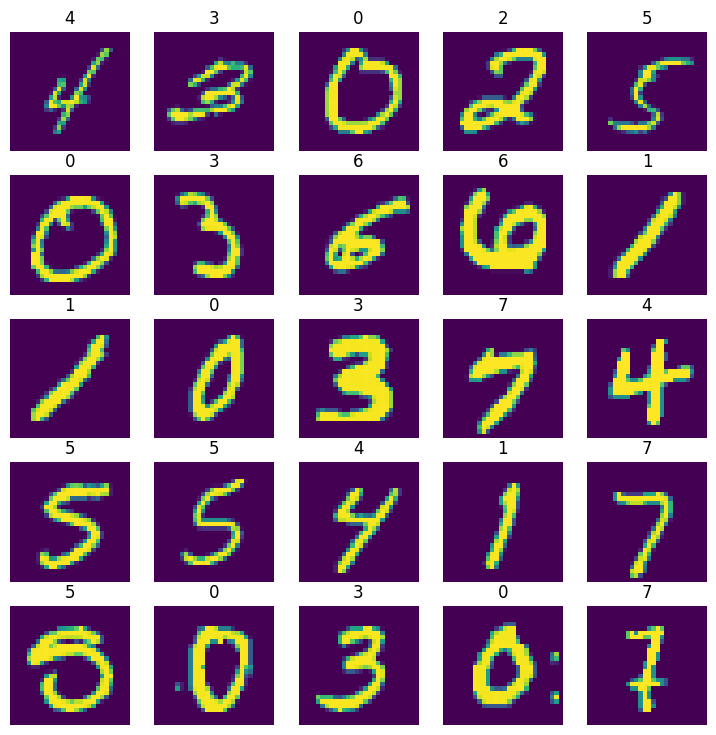

In [6]:
figure = plt.figure(figsize=(9,9))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(mapping[label])
    plt.axis('off')
    plt.imshow(img.squeeze())
plt.show()

In [7]:
train_features.shape

torch.Size([64, 1, 28, 28])

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=0.001)

n_epochs = 10
best_weights = None
best_accuracy = -np.inf
accuracy_hist = []
loss_hist = []

In [10]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for train_features, train_labels in (bar:=tqdm(train_dataloader, unit='batch')):
        bar.set_description(f'Epoch: {epoch+1}/{n_epochs}')
        train_features, train_labels = train_features.to(device), train_labels.to(device)
        output = model(train_features)

        loss = loss_fn(output, train_labels)
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        bar.set_postfix(loss=loss.item())
    
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for test_features, test_labels in (test_bar:=tqdm(test_dataloader, unit='batch')):
            test_bar.set_description(f'Testing for Epoch {epoch+1}')
            test_features, test_labels = test_features.to(device), test_labels.to(device)
            
            output = model(test_features)
            loss = loss_fn(output, test_labels)
            test_loss += loss.item()
            
            
            
            predicted = torch.argmax(output, dim=1)
            total += test_labels.shape[0]
            correct += (predicted == test_labels).sum().item()
            
            
    test_loss /= len(test_dataloader)
    scheduler.step(test_loss)
    loss_hist.append(test_loss)
    accuracy = 100 * correct/total
    
    print(f"Epoch {epoch+1} validation: Cross-entropy={test_loss:.2f}, Accuracy={accuracy:.1f}%, Lr={optimizer.param_groups[0]['lr']:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = copy.deepcopy(model.state_dict())
    accuracy_hist.append(accuracy)

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 1 validation: Cross-entropy=2.18, Accuracy=48.9%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2 validation: Cross-entropy=1.99, Accuracy=55.6%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3 validation: Cross-entropy=1.79, Accuracy=59.7%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4 validation: Cross-entropy=1.59, Accuracy=63.5%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5 validation: Cross-entropy=1.40, Accuracy=65.9%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 6 validation: Cross-entropy=1.23, Accuracy=73.6%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 7 validation: Cross-entropy=1.09, Accuracy=76.1%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 8 validation: Cross-entropy=1.00, Accuracy=77.6%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 9 validation: Cross-entropy=0.93, Accuracy=78.3%, Lr=0.0010


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 10 validation: Cross-entropy=0.87, Accuracy=78.7%, Lr=0.0010


In [11]:
def plot_line(input_data: list, title: str, legend: list, xlabel: str, ylabel: str, 
              save: bool = False, savename: str = None, show: bool = False):
    plt.style.use('ggplot')

    plt.figure()
    plt.plot(input_data)
    plt.title(title)
    if legend:
        plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save:
        plt.savefig(savename)
    if show:
        plt.show()
    

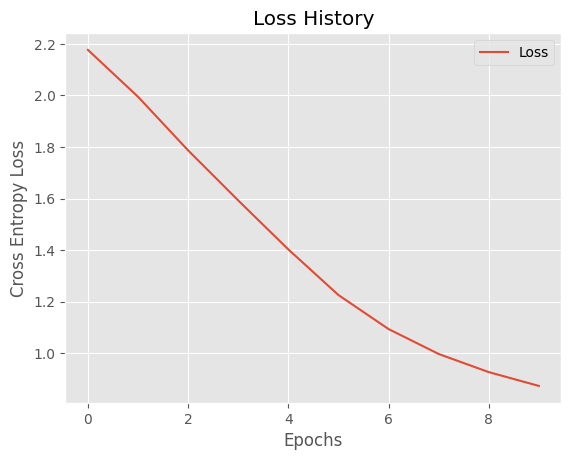

In [12]:
plot_line(loss_hist, 'Loss History', ['Loss'], 'Epochs', 
          'Cross Entropy Loss', True, 'loss_hist_mnist.png', True)

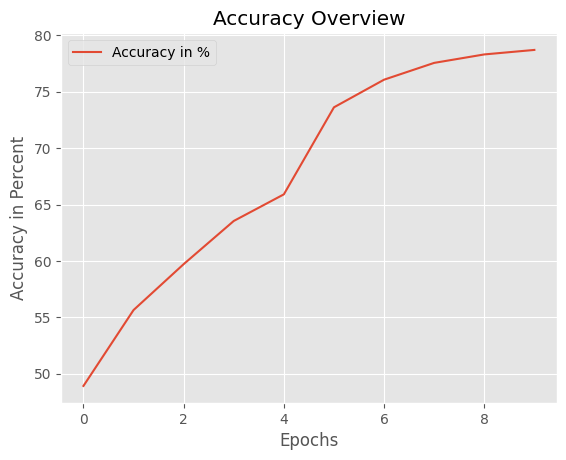

In [13]:
plot_line(accuracy_hist, 'Accuracy Overview', ['Accuracy in %'], 'Epochs', 
          'Accuracy in Percent', True, 'accuracy_hist_mnist.png', True)

### Getting the confusion matrix

  0%|          | 0/157 [00:00<?, ?batch/s]

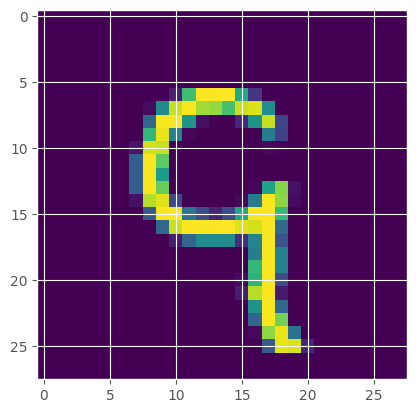

KeyboardInterrupt: 

In [52]:
model.load_state_dict(best_weights)

model.eval()
pred_list = []
true_list = []
wrong_list = []
for test_features, test_labels in (bar:=tqdm(test_dataloader, unit='batch')):
    out = model(test_features.to(device))
    pred_list += torch.argmax(out, axis=1).detach().cpu()
    true_list += test_labels
    
    
    for i in range(len(out)):
        if torch.argmax(out, axis=1).detach().cpu()[i] != test_labels[i]:
            wrong_list.append((test_features[i], torch.argmax(out, axis=1).detach().cpu()[i], test_labels[i]))

In [15]:
cf = confusion_matrix(true_list, pred_list)
cf

array([[ 949,    0,    4,    5,    0,    4,   12,    1,    5,    0],
       [   0, 1098,    6,    3,    0,    1,    4,    0,   23,    0],
       [  18,   36,  853,   28,   16,    0,   25,   19,   37,    0],
       [   6,    6,   29,  892,    0,   23,    6,   21,   27,    0],
       [   3,   21,    3,    2,  889,    5,   38,    4,   17,    0],
       [  32,   22,    7,  107,   19,  613,   35,    9,   48,    0],
       [  28,    8,   19,    2,   14,   18,  861,    0,    8,    0],
       [  11,   50,   33,    2,   13,    1,    0,  914,    4,    0],
       [  12,   25,   15,   46,   10,   19,   26,   19,  802,    0],
       [  22,   21,   21,   29,  556,   63,   11,  224,   62,    0]],
      dtype=int64)

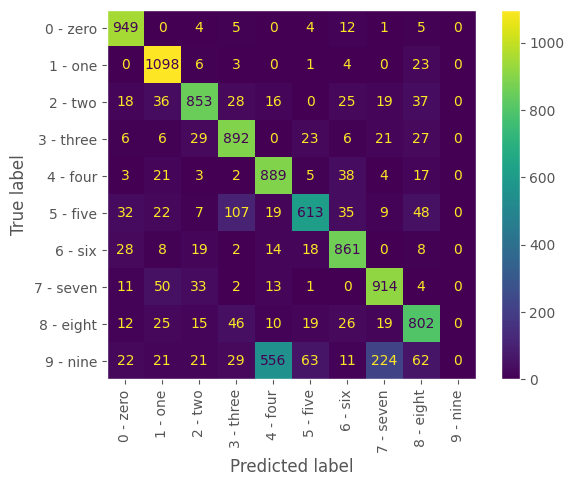

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=test_data.classes)
disp.plot()
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

C:\Users\leand\AppData\Local\Temp\ipykernel_7520\1347529057.py:3: RuntimeWarning: invalid value encountered in divide
  cf_percentage = (cf/col_sums)*100


Text(108.22222222222221, 0.5, 'Tatsächliche Klasse')

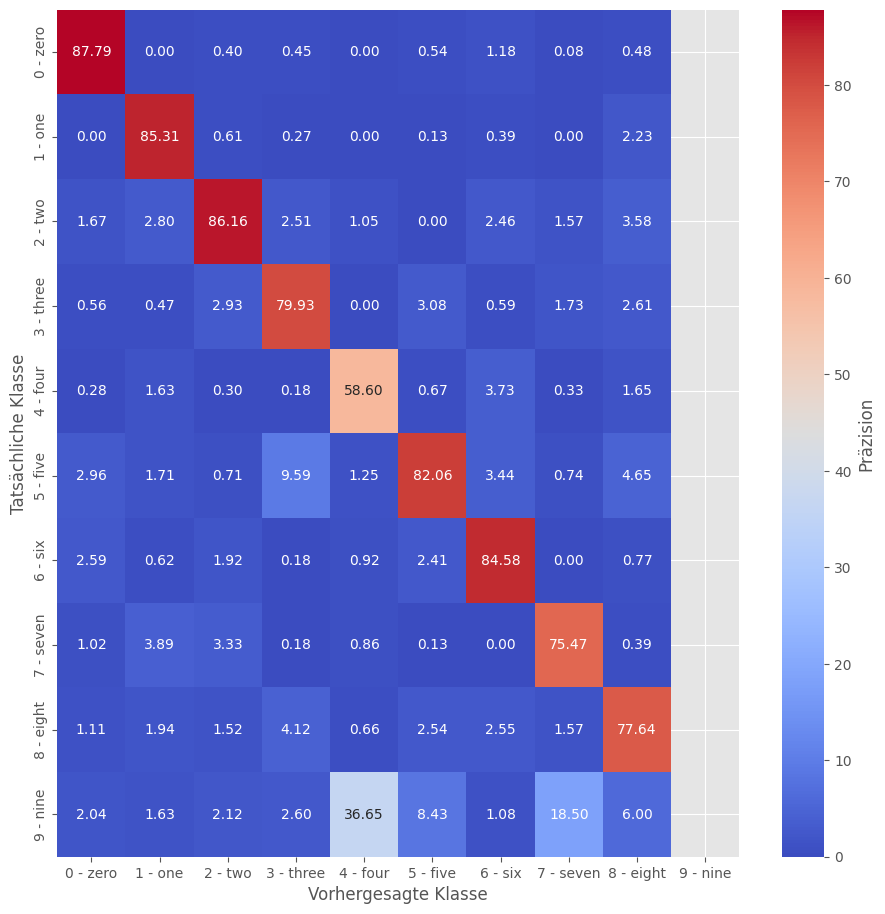

In [17]:
col_sums = cf.sum(axis=0, keepdims=True)

cf_percentage = (cf/col_sums)*100


plt.figure(figsize=(11, 11))
ax = sns.heatmap(cf_percentage, annot=True, fmt='.2f', xticklabels=test_data.classes, yticklabels=test_data.classes, cmap='coolwarm', cbar_kws={'label': 'Präzision'})

plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')



### Plotting wrong predictions for checkup

In [18]:
len(wrong_list)

2129

In [51]:
np.random.randint(len(wrong_list))

97

Predict: 4
Correct: 9


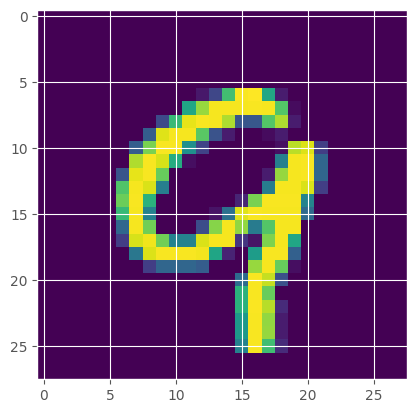

In [47]:
random_number = torch.randint(len(wrong_list), size=(1,)).item()

plt.imshow(wrong_list[random_number][0].squeeze())
print(f'Predict: {wrong_list[random_number][1].item()}')
print(f'Correct: {wrong_list[random_number][2].item()}')

C:\Users\leand\AppData\Local\Temp\ipykernel_7520\1632511610.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


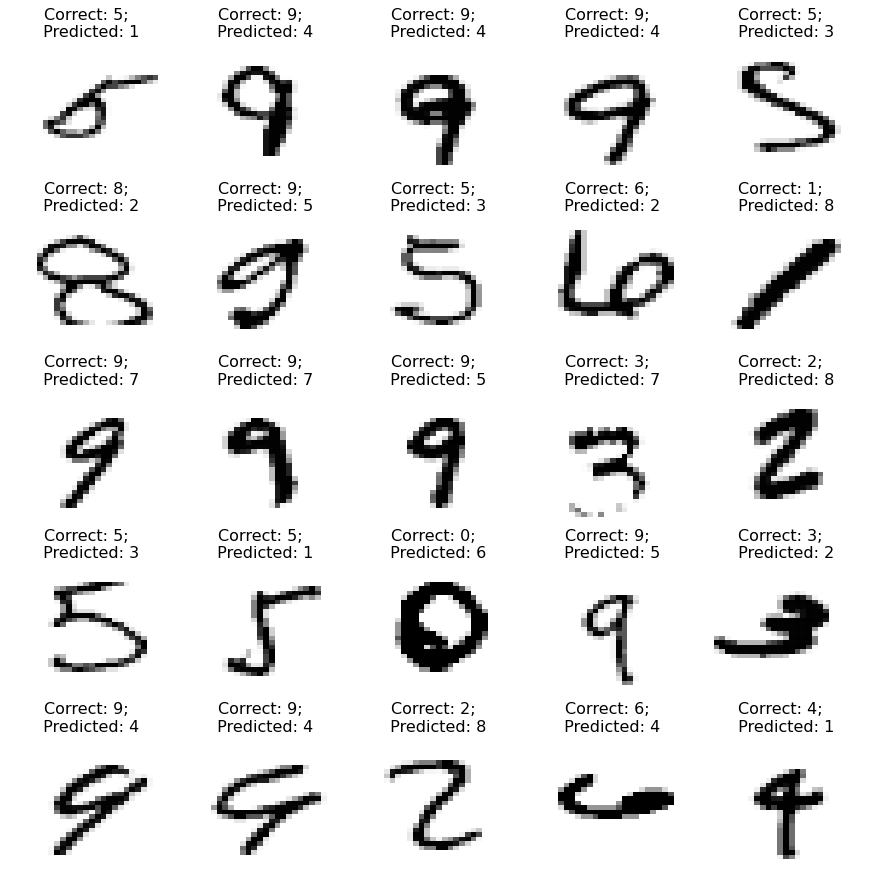

In [19]:
figure = plt.figure(figsize=(11, 11), dpi=80)
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(wrong_list), size=(1,))
    img, wrong_label,  correct_label = wrong_list[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Correct: {correct_label.item()}; \n Predicted: {wrong_label}')
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(img.squeeze(), aspect='auto', cmap='Greys')
plt.show()